In [1]:
%matplotlib inline

import numpy as np
import pandas as pd 
from skimage import io, color
import skimage
import matplotlib.pyplot as plt
import cv2
import numpy as np

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/image-colorization/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/image-colorization/ab/ab/ab3.npy
/kaggle/input/image-colorization/ab/ab/ab1.npy
/kaggle/input/image-colorization/ab/ab/ab2.npy
/kaggle/input/image-colorization/l/gray_scale.npy


**UTILS**

In [2]:
def display(img):
    plt.figure()
    plt.set_cmap('gray')
    plt.imshow(img)
    plt.show()


def combineLAB(l, a, b):
    shape = (l.shape[0], l.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = l
    zeros[:, :, 1] = a
    zeros[:, :, 2] = b
    return zeros


def combineAB(a, b):
    shape = (a.shape[0], b.shape[1], 2)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = a
    zeros[:, :, 1] = b
    return zeros


def combineL_AB(l, ab):
    shape = (l.shape[0], l.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = l
    zeros[:, :, 1] = ab[:, :, 0]
    zeros[:, :, 2] = ab[:, :, 1]
    return zeros


def make3channels(gray):
    shape = (gray.shape[0], gray.shape[1], 3)
    zeros = np.zeros(shape)
    zeros[:, :, 0] = gray
    zeros[:, :, 1] = gray
    zeros[:, :, 2] = gray
    return zeros


def get_l_from_gray(img_path):
    img = io.imread(img_path)
    img = skimage.transform.resize(img,(64,64))
    gray = color.rgb2gray(img)
    gray = make3channels(gray)
    lgray = color.rgb2lab(gray, illuminant='D50')[:, :, 0]
    return lgray


def get_ab_from_file(file):
    img = io.imread(file)
    ab = np.zeros((64, 64, 2))
    ab[:, :, 0] = img[:, :, 1]
    ab[:, :, 1] = img[:, :, 2]
    return ab


def lab_normal_image(path):
    l, ab = load_img_for_training(path)
    l, ab = (l-127.5)/127.5, (ab-127.5)/127.5
    return l, ab


def rgb_image(l, ab):
    shape = (l.shape[0],l.shape[1],3)
    img = np.zeros(shape)
    img[:,:,0] = l[:,:,0]
    img[:,:,1:]= ab
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img


def load_img_for_training(img_path):
    img = io.imread(img_path)
    img = skimage.transform.resize(img,(64,64))
    lab = color.rgb2lab(img, illuminant='D50')
    l, a, b = lab[:, :, 0], lab[:, :, 1], lab[:, :, 2]
    ab = combineAB(a, b)
    lgray = get_l_from_gray(img_path)
    return lgray, ab


def save_ab_file(image, filepath):
    # add in 0zeros to its first component
    shape = (image.shape[0], image.shape[1], 3)
    new_ab_image = np.zeros(shape)
    new_ab_image[:, :, 1] = image[:, :, 0]
    new_ab_image[:, :, 2] = image[:, :, 1]
    save_file(new_ab_image, filepath)


def save_file(image, filepath):
    io.imsave(filepath, image)


def load_ab_image(path):
    img = io.imread(path)
    shape = (img.shape[0], img.shape[1], 2)
    ab = np.zeros(shape)
    ab[:, :, 0] = img[:, :, 1]
    ab[:, :, 1] = img[:, :, 2]
    return ab


**Data Loading**

In [3]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [4]:
def normalize(image):
    # convert image from range 0-256 to 
    image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    image = image/255
    return image

def unnormalize(image):
    image = (image*255)
    return image.astype('uint8')

In [5]:
gray_scale = np.load('/kaggle/input/image-colorization/l/gray_scale.npy')
ab_scale = np.load('/kaggle/input/image-colorization/ab/ab/ab1.npy')
print(gray_scale.shape)
print(ab_scale.shape)

(25000, 224, 224)
(10000, 224, 224, 2)


In [6]:
x = np.zeros((10000,64,64,1))
y = np.zeros((10000,64,64,2))

for i in range(10000):
    l_sample = normalize(gray_scale[i])
    ab_sample = normalize(ab_scale[i])
    x[i] = l_sample.reshape((64,64,1))
    y[i] = ab_sample  

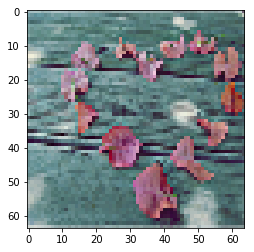

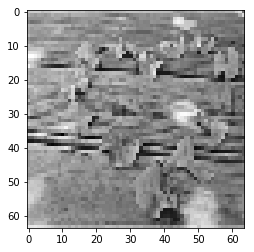

In [7]:
l_sample,ab_sample = unnormalize(x[1]),unnormalize(y[1])
rgb_sample = rgb_image(l_sample,ab_sample)
display(rgb_sample)
display(l_sample[:,:,0])

**Architecture**

In [8]:
from keras import *
from keras.layers import *
from keras.activations import *
from keras.optimizers import *
from matplotlib import pyplot as plt
from utils import *
from keras.initializers import RandomNormal, Zeros

Using TensorFlow backend.


In [9]:
def residual_block(feature, dropout=False):
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return Add()([feature, x])


def conv_block(feature, out_channel, downsample=True, dropout=False):
    if downsample:
        x = Conv2D(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    else:
        x = Conv2DTranspose(out_channel, kernel_size=4, strides=2, padding='same', kernel_initializer=RandomNormal(
            mean=0.0, stddev=0.02), bias_initializer=Zeros())(feature)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout:
        x = Dropout(0.5)(x)
    return x


def build_model(n_block=5):
    image_size = 64
    input_channel = 1
    output_channel = 2
    input = Input(shape=(image_size, image_size, input_channel))
    x = Conv2D(64, kernel_size=7, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(input)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # downsample
    x = Conv2D(256, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    for i in range(n_block):
        x = residual_block(x)
    # upsample
    x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same',
                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # upsample
    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # out
    x = Conv2D(output_channel, kernel_size=7, padding='same', kernel_initializer=RandomNormal(
        mean=0.0, stddev=0.02), bias_initializer=Zeros())(x)  # use reflection padding instead
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    model = Model(inputs=input, outputs=x)
    model.summary()
    return model

def save_images(generator, samples):
    ab_values = generator.predict(samples)
    plt.figure()
    plt.set_cmap('gray')
    for i in range(ab_values.shape[0]):
        l_val = unnormalize(samples[i])
        ab_val = unnormalize(ab_values[i])
        rgb = rgb_image(l_val, ab_val)
        if i == 0:
            display(rgb)
        ax = plt.subplot(4, 4, i+1)
        im = ax.imshow(rgb)
        plt.tight_layout()
        plt.title(i)
    plt.show()
    plt.savefig('gan_generated_image.png')


    
def train_network(x_data,y_data,epochs=100, batch_size=128, save_interval=5):
    input_shape = (64, 64, 1)
    output_shape = (64, 64, 2)
    model = build_model(7)
    model.compile(optimizer='adam', loss='mse', metrics=['mse','acc'])
    history = model.fit(x_data,y_data,validation_split=0.1,epochs=epochs,batch_size=128,)
    model.save('model.h5')
    print("MODEL SAVED")
    return model,history
    


In [10]:
samples = x.shape[0]
x = x.reshape((samples,64,64,1))
model,history=train_network(x,y,epochs=500)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

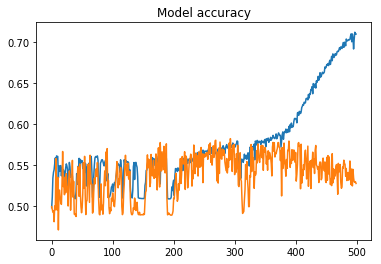

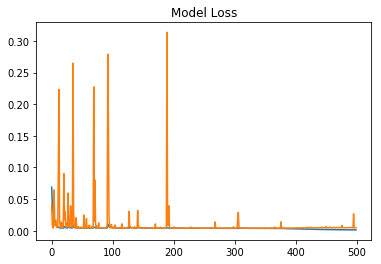

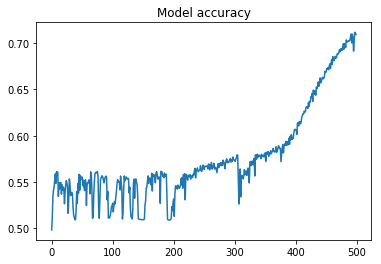

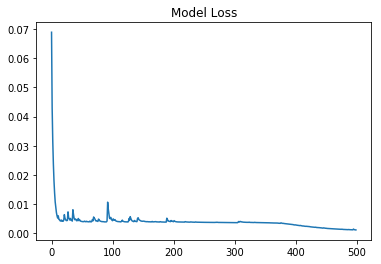

In [11]:
h = history
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model Loss')
plt.show()

plt.plot(h.history['acc'])
plt.title('Model accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.title('Model Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

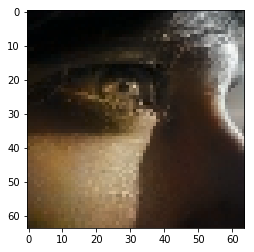

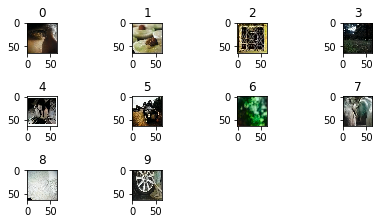

<Figure size 432x288 with 0 Axes>

In [12]:
samples = x[50:60]
save_images(model,samples)